# Neural Style Transfer

In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import model_zoo, nn
import time

## Read the Content and Style Images

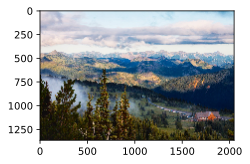

In [2]:
d2l.set_figsize()
content_img = image.imread('rainier.jpg')
d2l.plt.imshow(content_img.asnumpy());

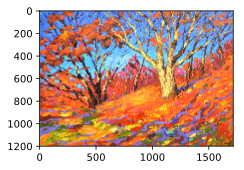

In [3]:
style_img = image.imread('autumn_oak.jpg')
d2l.plt.imshow(style_img.asnumpy());

## Features 

### Preprocessing and Postprocessing

In [4]:
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis=0)

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)

### Select Content and Style Layers

In [5]:
pretrained_net = model_zoo.vision.vgg19(pretrained=True)

style_layers, content_layers = [0, 5, 10, 19, 28], [25]

net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

### Extract Features 

In [6]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

### Get Contents and Style Features

In [7]:
def get_contents(image_shape, ctx):
    content_X = preprocess(content_img, image_shape).copyto(ctx)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, ctx):
    style_X = preprocess(style_img, image_shape).copyto(ctx)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## Define the Loss Function


### Content Loss


In [8]:
def content_loss(Y_hat, Y):
    return (Y_hat - Y).square().mean()

### Style Loss

In [9]:
def gram(X):
    num_channels, n = X.shape[1], X.size // X.shape[1]
    X = X.reshape((num_channels, n))
    return nd.dot(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return (gram(Y_hat) - gram_Y).square().mean()

### Total Variance Loss

In [10]:
def tv_loss(Y_hat):
    return 0.5 * ((Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).abs().mean() +
                  (Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).abs().mean())

### Loss Function

In [11]:
style_channels = [net[l].weight.shape[0] for l in style_layers]
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

## Create and Initialize the Composite Image

In [12]:
class GeneratedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

### Initialize

In [13]:
def get_inits(X, ctx, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'sgd',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## Train

In [14]:
def train(X, contents_Y, styles_Y, ctx, lr, max_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, ctx, lr, styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        nd.waitall()
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, nd.add_n(*contents_l).asscalar(),
                     nd.add_n(*styles_l).asscalar(), tv_l.asscalar(),
                     time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
            print('change lr to %.1e' % trainer.learning_rate)
    return X

### Train a 300 x 200 composite image 

epoch  50, content loss 7.12, style loss 14.02, TV loss 3.26, 0.05 sec
epoch 100, content loss 5.50, style loss 9.55, TV loss 3.41, 0.05 sec
epoch 150, content loss 5.04, style loss 7.49, TV loss 3.49, 0.05 sec
epoch 200, content loss 4.69, style loss 6.57, TV loss 3.54, 0.05 sec
change lr to 5.0e-01
epoch 250, content loss 4.47, style loss 6.40, TV loss 3.54, 0.05 sec
epoch 300, content loss 4.43, style loss 6.32, TV loss 3.54, 0.05 sec
epoch 350, content loss 4.40, style loss 6.25, TV loss 3.54, 0.05 sec
epoch 400, content loss 4.37, style loss 6.19, TV loss 3.54, 0.05 sec
change lr to 5.0e-02
epoch 450, content loss 4.36, style loss 6.18, TV loss 3.54, 0.05 sec


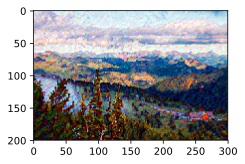

In [19]:
ctx, image_shape = d2l.try_gpu(), (300, 200)
net.collect_params().reset_ctx(ctx)
content_X, contents_Y = get_contents(image_shape, ctx)
style_X, styles_Y = get_styles(image_shape, ctx)
output = train(content_X, contents_Y, styles_Y, ctx, 5, 500, 200)
d2l.plt.imsave('neural-style-1.png', postprocess(output).asnumpy())

### Visualize 

![](neural-style-1.png)

### Train a larger composite image 

In [20]:
image_shape = (1200, 800)
content_X, content_Y = get_contents(image_shape, ctx)
style_X, style_Y = get_styles(image_shape, ctx)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, ctx, 1, 300, 100)
d2l.plt.imsave('neural-style-2.png', postprocess(output).asnumpy())

epoch  50, content loss 20.51, style loss 43.77, TV loss 0.74, 0.93 sec
epoch 100, content loss 17.54, style loss 31.44, TV loss 0.77, 1.00 sec
change lr to 1.0e-01
epoch 150, content loss 17.29, style loss 30.58, TV loss 0.77, 1.16 sec
epoch 200, content loss 17.09, style loss 29.90, TV loss 0.77, 0.95 sec
change lr to 1.0e-02
epoch 250, content loss 17.07, style loss 29.83, TV loss 0.78, 1.00 sec


### Visualize 

![](neural-style-2.png)

With a larger resolution:
![](./d2l-front.png)